1. 기본적인 feature engineering을 통한 데이터를 이용하여 ml model에 적용하였을 때, 성능을 확인한다(base line)

2. 추후에 eda를 통한 새로운 feature를 추가하면 어떻게 변하는지 살펴보자

3. 2의 결과 성능이 향상되면 hyperparameter tuning까지 기대해볼 수 있다

4. 최종적으로 Stack과 Bagging으로 성능을 끌어올려보자

In [1]:
from bayes_opt import BayesianOptimization

In [2]:
import pandas as pd
import warnings 
warnings.filterwarnings('ignore')

train = pd.read_csv('dataset/train.csv', index_col=0)
test = pd.read_csv('dataset/test.csv', index_col=0)
train.shape, test.shape

((17480, 15), (15081, 14))

# 1. Basic feature engineering

In [3]:
label = set(train.columns) - set(test.columns)
label = ' '.join(label)
label

'target'

In [4]:
def nullCheck(df):
    """ check df and return columns having null value """
    null_columns = []
    for col in df.columns:
        n_null_values = df[col].isnull().sum()
        isNull = True if n_null_values>0 else False
        if isNull:
            print(f'{col} have {n_null_values} na values')
            null_columns.append([col, df[col].dtype])
    if len(null_columns) == 0:
        print('no NA')
    return null_columns

null_cols = nullCheck(train)

workclass have 1836 na values
occupation have 1843 na values
native.country have 583 na values


In [5]:
for col, _ in null_cols:
    print(f'{col} has {train[col].isnull().sum()/len(train[col])*100:.2f}%')
    print(train[col].unique())

workclass has 10.50%
['Private' 'State-gov' 'Local-gov' 'Self-emp-not-inc' 'Self-emp-inc'
 'Federal-gov' 'Without-pay' nan 'Never-worked']
occupation has 10.54%
['Craft-repair' 'Exec-managerial' 'Adm-clerical' 'Prof-specialty'
 'Machine-op-inspct' 'Other-service' 'Sales' 'Farming-fishing'
 'Transport-moving' 'Handlers-cleaners' 'Tech-support' 'Protective-serv'
 'Priv-house-serv' 'Armed-Forces' nan]
native.country has 3.34%
['United-States' 'Poland' 'Mexico' 'Ireland' 'Guatemala'
 'Dominican-Republic' 'Greece' 'El-Salvador' 'Portugal' 'Canada'
 'Philippines' 'India' 'Italy' 'England' 'Jamaica' 'Columbia' 'South'
 'Vietnam' 'Cuba' 'Laos' 'Hong' 'Haiti' 'Germany' 'Yugoslavia' 'Ecuador'
 'France' 'Puerto-Rico' 'Outlying-US(Guam-USVI-etc)' 'Taiwan' 'China'
 'Japan' 'Honduras' 'Peru' 'Nicaragua' 'Hungary' 'Cambodia' 'Iran'
 'Trinadad&Tobago' 'Thailand' 'Scotland' 'Holand-Netherlands' nan]


In [6]:
# def dropCols(df, columns):
#     cols_to_drop = [col[0] for col in columns]
#     df.drop(cols_to_drop, axis=1, inplace=True)
#     return df
# train = dropCols(train, null_cols)
# test = dropCols(test, null_cols)
# train.shape, test.shape

In [7]:
from collections import Counter
index = [] 
mis_var_col = [col[0] for col in null_cols]
index.extend(train[train[mis_var_col[0]].isnull()].index)
index.extend(train[train[mis_var_col[1]].isnull()].index)
index.extend(train[train[mis_var_col[2]].isnull()].index)

mis_index = []
for k, v in Counter(index).items():
    if v>=2: mis_index.append(k)

len(mis_index)
del index
train.drop(mis_index, axis=0, inplace=True)
train.shape

(15644, 15)

In [8]:
train['occupation'].fillna('Exec-managerial', inplace=True)

In [9]:
train['native.country'].fillna('United-States', inplace=True)

In [10]:
train.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
target            0
dtype: int64

In [11]:
def label_encoder(df, categorical_columns=None):
    if not categorical_columns:
        categorical_columns = [col for col in df.columns if df[col].dtype=='object']
    for col in categorical_columns:
        df[col], uniques = pd.factorize(df[col])
    return df, categorical_columns
    
train, categorical_features = label_encoder(train)
test, categorical_features = label_encoder(test)
print(f'{categorical_features} are encoded')

['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'native.country'] are encoded


# 2. Basic modeling

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier

names = ['LR', 'SVM', 'KNN', 'MLP', 'DT', 'RF', 'XGB', 'LGBM', 'CBM']
models = []
models.append(LogisticRegression(random_state=0))
models.append(SVC(kernel='rbf'))
models.append(KNeighborsClassifier())
models.append(MLPClassifier(random_state=0))
models.append(DecisionTreeClassifier(random_state=0))
models.append(RandomForestClassifier(random_state=0))
models.append(XGBClassifier(random_state=0))
models.append(LGBMClassifier(random_state=0))
models.append(CatBoostClassifier(random_state=0))


In [14]:
y_train = train[label]
X_train = train.drop(label, axis=1)
X_test = test
print(X_train.shape, y_train.shape, X_test.shape)

(15644, 14) (15644,) (15081, 14)


In [15]:
X_train.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
id,,,,,,,,,,,,,,
0,32,0,309513,0,12,0,0,0,0,0,0,0,40,0
1,33,0,205469,1,10,0,1,0,0,0,0,0,40,0
2,46,0,149949,1,10,0,0,0,0,0,0,0,40,0
3,23,0,193090,2,13,1,2,1,0,1,0,0,30,0
4,55,0,60193,3,9,2,2,2,0,1,0,0,40,0


### 5 fold CV of LR ###
CV mean:0.789951 +- std:0.003881

### 5 fold CV of SVM ###
CV mean:0.779212 +- std:0.009742

### 5 fold CV of KNN ###
CV mean:0.759268 +- std:0.006304

### 5 fold CV of MLP ###
CV mean:0.667228 +- std:0.210562

### 5 fold CV of DT ###
CV mean:0.799923 +- std:0.002783

### 5 fold CV of RF ###
CV mean:0.848313 +- std:0.005785

### 5 fold CV of XGB ###
CV mean:0.861417 +- std:0.008947

### 5 fold CV of LGBM ###
CV mean:0.865380 +- std:0.002330

### 5 fold CV of CBM ###
CV mean:0.865123 +- std:0.006771



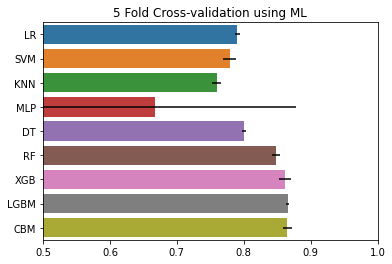

In [18]:
from sklearn.model_selection import KFold, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
kfold = KFold(n_splits=5, shuffle=True)

cv_results = []
for i in range(len(names)):
    print(f'### 5 fold CV of {names[i]} ###')
    cv_result = cross_val_score(models[i], X_train, y_train, 
                                cv=kfold, scoring='accuracy', n_jobs=-1)
    cv_results.append(cv_result)
    print(f'CV mean:{cv_result.mean():.6f} +- std:{cv_result.std():.6f}\n')
    


cv_means = [ x.mean() for x in cv_results ]
cv_std = [ x.std() for x in cv_results ]
cv = {
    'models':names,
    'cv_means':cv_means,
    'cv_std':cv_std
}
sns.barplot(y='models', x='cv_means', 
            data=cv, orient='h', 
            **{'xerr':cv_std})
plt.title("5 Fold Cross-validation using ML")
plt.xlim(0.5,1)
plt.show()

# 3. Prediction using ensemble

In [22]:
from sklearn.ensemble import VotingClassifier
votingC = VotingClassifier(estimators=[('RF', RandomForestClassifier(random_state=0)),
                                      ('XGB', XGBClassifier(random_state=0)),
                                      ('LGBM', LGBMClassifier(random_state=0)),
                                      ('CBM', CatBoostClassifier()),
                                      ],
                          voting='hard', n_jobs=-1)

# cv_result = cross_val_score(votingC, X_train, y_train, cv=5, scoring='accuracy')
# print('The cross validation score is {}'.format(cv_result.mean()))


votingC.fit(X_train,y_train)
predictions = votingC.predict(X_test)
sub = pd.read_csv('dataset/sample_submission.csv')
sub['target'] = predictions
sub.to_csv('result/day2.csv', index=False)


In [36]:
from sklearn.ensemble import BaggingClassifier
baggingC = BaggingClassifier(base_estimator=LGBMClassifier(random_state=0))

# cv_result = cross_val_score(baggingC, X_train, y_train, cv=5, scoring='accuracy')
# print('The cross validation score is {}'.format(cv_result.mean()))


votingC.fit(X_train,y_train)
predictions = votingC.predict(X_test)
sub = pd.read_csv('dataset/sample_submission.csv')
sub['target'] = predictions
sub.to_csv('result/day2.csv', index=False)


In [ ]:
CV mean:0.865380 +- std:0.002330

In [32]:
# 1. bound
rf_parameter_bounds = {
    'max_samples':(1,20),
    'max_features':(1,20),
    'n_estimators':(10,30)
}
# bound ftn > 성능 발현
def rf_bo(max_samples, max_features, n_estimators):
    """
    input: bound의 key
    param으로 받아 score를 산출할 수 있도록 함
    """
    rf_params={
        'max_samples':int(round(max_samples)),
        'max_features':int(round(max_features)),
        'n_estimators':int(round(n_estimators))
    }
    baggingC = BaggingClassifier(base_estimator=LGBMClassifier(random_state=0))
    score = cross_val_score(baggingC, X_train, y_train, cv=kfold, scoring='accuracy', n_jobs=-1)
    return score.mean()

BO_rf = BayesianOptimization(f=rf_bo, pbounds=rf_parameter_bounds, random_state=0)
BO_rf.maximize(init_points=5, n_iter=5)

|   iter    |  target   | max_fe... | max_sa... | n_esti... |
-------------------------------------------------------------
|  1        |  0.8658   |  11.43    |  14.59    |  22.06    |
|  2        |  0.8665   |  11.35    |  9.049    |  22.92    |
|  3        |  0.8644   |  9.314    |  17.94    |  29.27    |
|  4        |  0.8641   |  8.285    |  16.04    |  20.58    |
|  5        |  0.8654   |  11.79    |  18.59    |  11.42    |
|  6        |  0.8648   |  13.71    |  14.5     |  26.93    |
|  7        |  0.8649   |  5.375    |  19.19    |  17.66    |
|  8        |  0.867    |  11.28    |  11.51    |  24.65    |
|  9        |  0.8661   |  9.822    |  9.553    |  25.83    |
|  10       |  0.8638   |  13.64    |  11.41    |  22.96    |


In [35]:
max_params = BO_rf.max['params']
max_params['max_samples'] = int(max_params['max_samples'])
max_params['max_features'] = int(max_params['max_features'])
max_params['n_estimators'] = int(max_params['n_estimators'])
print(max_params)

baggingC = BaggingClassifier(base_estimator=LGBMClassifier(random_state=0),**max_params)
score = cross_val_score(baggingC, X_train, y_train, cv=kfold, scoring='accuracy', n_jobs=-1)
score.mean()

{'max_features': 11, 'max_samples': 11, 'n_estimators': 24}


0.7804924683617245

In [15]:
BO_tuend_rf = LGBMClassifier(**max_params)
score = cross_val_score(BO_tuend_rf, X_train, y_train, cv=kfold, scoring='accuracy', n_jobs=-1)
score.mean()

0.865045766590389

In [16]:
# sub = pd.read_csv('dataset/sample_submission.csv')
# sub['target'] = pred
# sub.to_csv('result/day1.csv', index=False)